## install/update/import/clone

In [ ]:
!pip install -q torchmetrics

In [ ]:
# Создаем папку для репозитория
!mkdir object_foto_dataset
%cd object_foto_dataset

# Инициализируем пустой репозиторий
!git init

# Добавляем удаленный репозиторий
!git remote add origin https://github.com/torpedonosec80/object_foto_dataset.git

# Включаем sparse checkout
!git config core.sparseCheckout true

# Указываем путь к нужной директории (models_selection/analitic)
!echo "boxes_dataset" >> .git/info/sparse-checkout

# Загружаем только указанную директорию
!git pull origin main  # или master, если используется другая ветка

%cd '/content'

fatal: destination path 'object_foto_dataset' already exists and is not an empty directory.


In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision
import xml.etree.ElementTree as ET
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from torchmetrics.detection import MeanAveragePrecision
import gc
from copy import deepcopy
from datetime import datetime
from google.colab import drive
import shutil

In [ ]:
# Подключение Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## config

In [ ]:
# Конфигурация
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
CLASSES = {
    0: 'background',
    1: 'shta-9m',
    2: 'shta-ps',
    3: 'shta-7m',
    4: 'e2-6u',
    5: 'shta-9',
    6: 'shta-3',
    7: 'sv-5'
}
CLASS_NAME_TO_ID = {v: k for k, v in CLASSES.items()}
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 4  # Уменьшили batch size из-за больших требований к памяти
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
PRINT_FREQ = 20

# Путь к данным
DATA_DIR = "/content/object_foto_dataset/boxes_dataset"

## datasets

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.images = [f for f in os.listdir(img_dir)
                      if f.endswith(('.jpeg', '.jpg', '.JPG', '.png'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        ann_path = os.path.join(self.ann_dir, os.path.splitext(img_name)[0] + '.xml')

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        boxes = []
        labels = []

        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in CLASS_NAME_TO_ID:
                continue
            label = CLASS_NAME_TO_ID[class_name]
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels}

        if self.transforms:
            image = self.transforms(image)

        return image, target, img_name

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

## transforms

In [ ]:
# Трансформации
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Создание полного датасета
full_dataset = CustomDataset(DATA_DIR, DATA_DIR, transform)

# Разделение данных
indices = list(range(len(full_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.176, random_state=42)

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f"Dataset sizes: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Dataset sizes: Train=654, Val=140, Test=141


In [ ]:
def get_model(num_classes):
    # Загрузка предобученной модели Faster R-CNN с бэкбоном ResNet-50 FPN
    weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

    # Получаем количество входных признаков для классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Заменяем классификатор на новый с нужным количеством классов
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model.to(DEVICE)

In [ ]:
model = get_model(NUM_CLASSES)

In [ ]:
def calculate_map(model, data_loader, device):
    model.eval()
    try:
        metric = MeanAveragePrecision(
            iou_thresholds=[0.5, 0.75],
            class_metrics=True
        )

        with torch.no_grad():
            for batch in data_loader:
                if batch is None:
                    continue

                images, targets, names = batch
                if not images or len(images) == 0:
                    continue

                images = [img.to(device) for img in images]
                outputs = model(images)

                preds = []
                for output in outputs:
                    preds.append({
                        'boxes': output['boxes'].cpu(),
                        'scores': output['scores'].cpu(),
                        'labels': output['labels'].cpu()
                    })

                gt = []
                for target in targets:
                    gt.append({
                        'boxes': target['boxes'].cpu(),
                        'labels': target['labels'].cpu()
                    })

                metric.update(preds, gt)

        return metric.compute()

    except Exception as e:
        print(f"Error in mAP calculation: {e}")
        return {
            'map': torch.tensor(0.0),
            'map_50': torch.tensor(0.0),
            'map_75': torch.tensor(0.0)
        }

## обучение

In [ ]:
# Оптимизатор и планировщик
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

os.makedirs('saved_models', exist_ok=True)
best_map = 0.0
best_model_weights = None
train_losses = []
val_maps = []

Epoch: 1/30, Batch: 1, Loss: 2.3172
Epoch: 1/30, Batch: 21, Loss: 0.3872
Epoch: 1/30, Batch: 41, Loss: 0.2194
Epoch: 1/30, Batch: 61, Loss: 0.2643
Epoch: 1/30, Batch: 81, Loss: 0.3250
Epoch: 1/30, Batch: 101, Loss: 0.1827
Epoch: 1/30, Batch: 121, Loss: 0.2635
Epoch: 1/30, Batch: 141, Loss: 0.2788
Epoch: 1/30, Batch: 161, Loss: 0.2441
Epoch 1 Train Loss: 0.3035
Epoch 1 Validation mAP: 0.1780
Validation metrics: mAP@50=0.2979, mAP@75=0.0580
New best model saved with mAP 0.1780 at saved_models/best_model.pth
Epoch: 2/30, Batch: 1, Loss: 0.2224
Epoch: 2/30, Batch: 21, Loss: 0.2210
Epoch: 2/30, Batch: 41, Loss: 0.3160
Epoch: 2/30, Batch: 61, Loss: 0.3171
Epoch: 2/30, Batch: 81, Loss: 0.1741
Epoch: 2/30, Batch: 101, Loss: 0.2034
Epoch: 2/30, Batch: 121, Loss: 0.2097
Epoch: 2/30, Batch: 141, Loss: 0.1881
Epoch: 2/30, Batch: 161, Loss: 0.1523
Epoch 2 Train Loss: 0.2468
Epoch 2 Validation mAP: 0.4476
Validation metrics: mAP@50=0.5769, mAP@75=0.3184
New best model saved with mAP 0.4476 at saved_

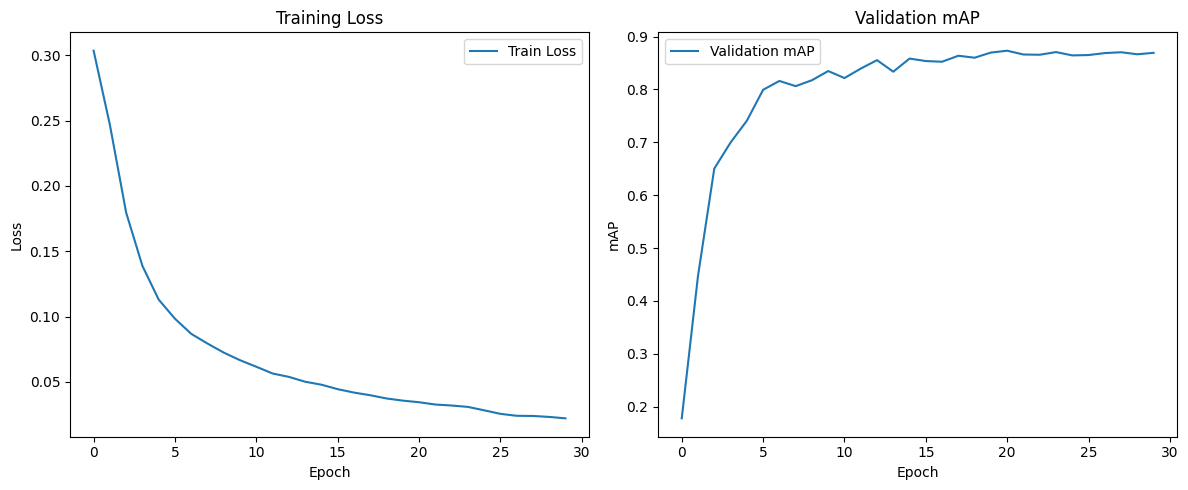

CPU times: user 2h 17min 18s, sys: 10min 4s, total: 2h 27min 22s
Wall time: 2h 28min 7s


In [ ]:
%%time
# Основной цикл обучения
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    for i, (images, targets, _) in enumerate(train_loader):
        images = [img.to(DEVICE) for img in images]
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        if i % PRINT_FREQ == 0:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS}, Batch: {i+1}, Loss: {losses.item():.4f}')

    epoch_avg_loss = epoch_loss / len(train_loader)
    train_losses.append(epoch_avg_loss)
    print(f'Epoch {epoch+1} Train Loss: {epoch_avg_loss:.4f}')

    val_metrics = calculate_map(model, val_loader, DEVICE)
    val_map = val_metrics['map'].item()
    val_maps.append(val_map)

    print(f'Epoch {epoch+1} Validation mAP: {val_map:.4f}')
    print(f'Validation metrics: mAP@50={val_metrics["map_50"].item():.4f}, mAP@75={val_metrics["map_75"].item():.4f}')

    scheduler.step(val_map)

    torch.cuda.empty_cache()
    gc.collect()

    if (epoch + 1) % 5 == 0:
        checkpoint_path = f'saved_models/checkpoint_epoch_{epoch+1}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_avg_loss,
            'val_map': val_map,
        }, checkpoint_path)
        print(f'Saved checkpoint: {checkpoint_path}')

    if val_map > best_map:
        best_map = val_map
        best_model_weights = deepcopy(model.state_dict())
        best_model_path = 'saved_models/best_model.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_weights,
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_avg_loss,
            'val_map': val_map,
        }, best_model_path)
        print(f'New best model saved with mAP {best_map:.4f} at {best_model_path}')

final_model_path = 'saved_models/final_model.pth'
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': epoch_avg_loss,
    'val_map': val_map,
}, final_model_path)
print(f'Training complete. Final model saved at {final_model_path}')

test_metrics = calculate_map(model, test_loader, DEVICE)
test_map = test_metrics['map'].item()
print(f'\n=== Final Test Results ===')
print(f'Test mAP: {test_map:.4f}')
print(f'Test mAP@50: {test_metrics["map_50"].item():.4f}')
print(f'Test mAP@75: {test_metrics["map_75"].item():.4f}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_maps, label='Validation mAP')
plt.title('Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

In [ ]:
# Сохранение результатов в Google Drive
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_folder = f"/content/drive/MyDrive/object_detection_results/{current_time}"
os.makedirs(save_folder, exist_ok=True)

shutil.copytree('/content/saved_models', os.path.join(save_folder, "saved_models"))
shutil.copy('training_metrics.png', os.path.join(save_folder, "training_metrics.png"))

with open(os.path.join(save_folder, 'test_results.txt'), 'w') as f:
    f.write(f"Final Test Results\n")
    f.write(f"Test mAP: {test_map:.4f}\n")
    f.write(f"Test mAP@50: {test_metrics['map_50'].item():.4f}\n")
    f.write(f"Test mAP@75: {test_metrics['map_75'].item():.4f}\n")

print(f"All results saved to: {save_folder}")

All results saved to: /content/drive/MyDrive/object_detection_results/2025-06-30_10-29-13


## image detection

In [ ]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.3):
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axs = plt.subplots(num_samples, 1, figsize=(12, 6*num_samples))

    for idx, ax in zip(indices, axs):
        image, target, img_name = dataset[idx]

        with torch.no_grad():
            prediction = model([image.to(DEVICE)])[0]

        img = image.cpu().permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"File: {img_name}", fontsize=12, pad=10)

        for score, box, label in zip(prediction['scores'], prediction['boxes'], prediction['labels']):
            if score > threshold:
                box = box.cpu().numpy()
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                        linewidth=1.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                label_name = CLASSES[label.item()]
                ax.text(box[0] + 2, box[1] + 10,
                        f'{label_name} {score:.4f}',
                        color='white', fontsize=10,
                        bbox=dict(facecolor='red', alpha=0.8))

        for box, label in zip(target['boxes'], target['labels']):
            box = box.cpu().numpy()
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   linewidth=1, edgecolor='g', facecolor='none', linestyle=':')
            ax.add_patch(rect)
            ax.text(box[2] - 2, box[1] + 10,
                   f'TRUE: {CLASSES[label.item()]}',
                   color='green', fontsize=8,
                   bbox=dict(facecolor='white', alpha=0.7),
                   horizontalalignment='right')

    plt.tight_layout()
    plt.show()

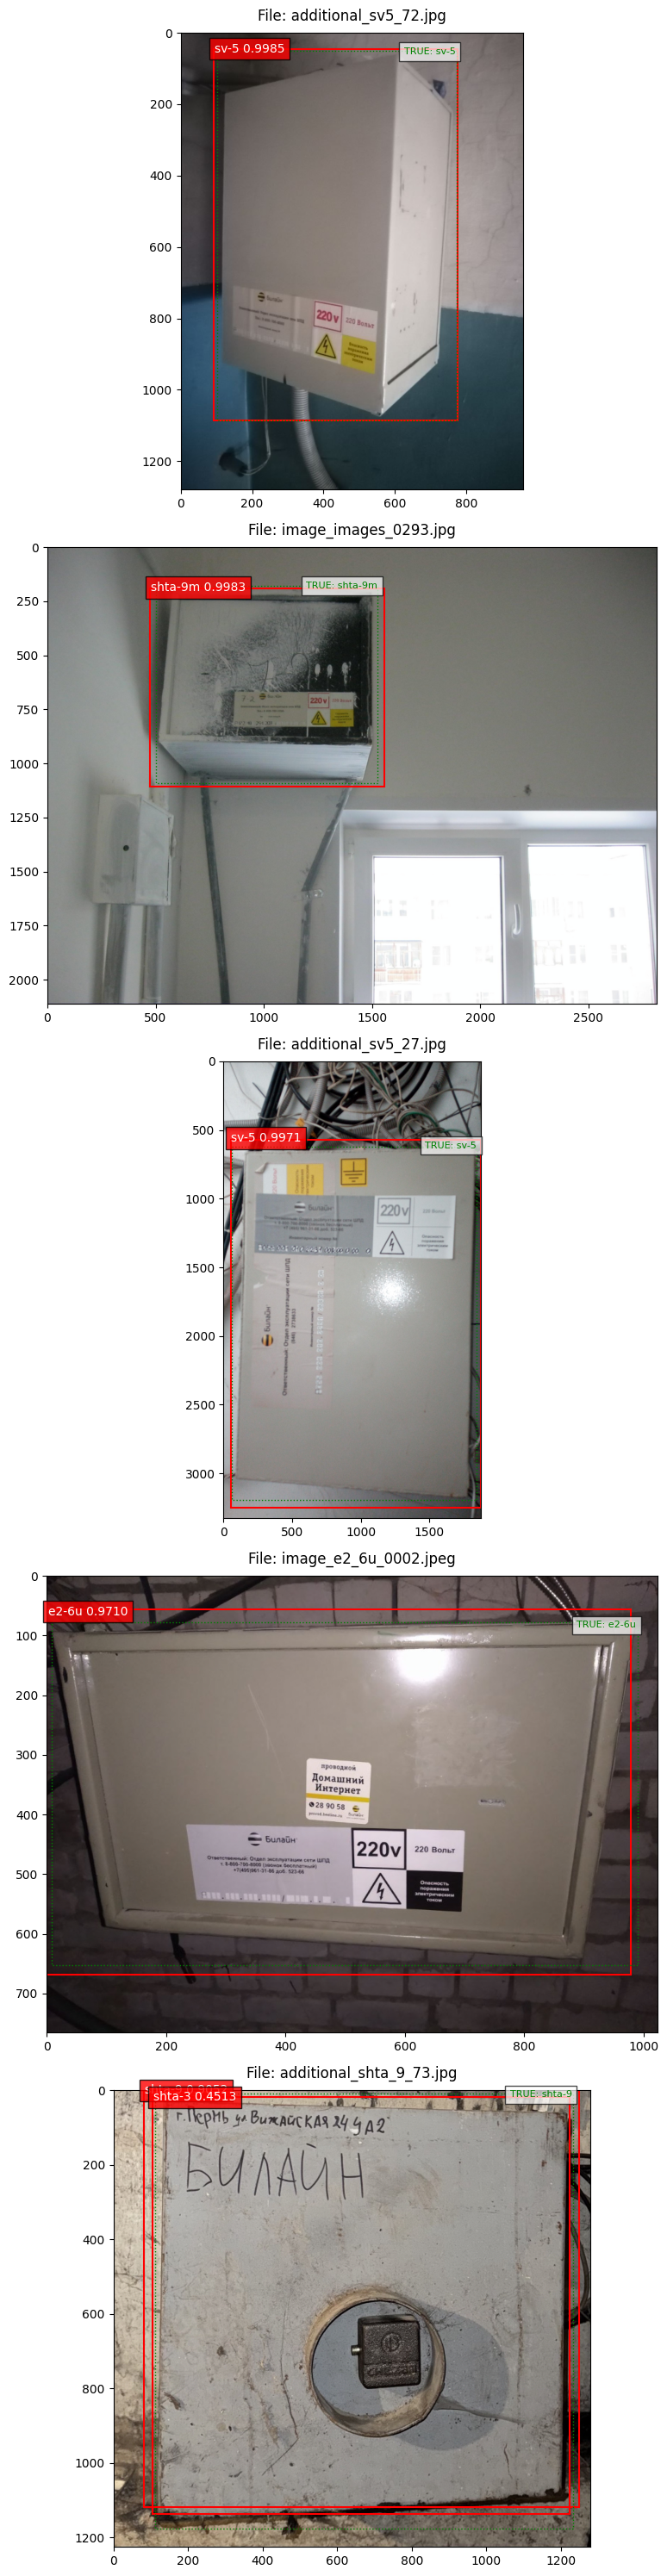

In [ ]:
visualize_predictions(model, val_dataset, num_samples=5)

## detection to df

In [ ]:
import pandas as pd
from tqdm import tqdm

MODEL_PATH = '/content/saved_models/best_model.pth'
THRESHOLD = 0.5
INFERENCE_DIR = DATA_DIR

In [ ]:
class InferenceDataset(Dataset):
    def __init__(self, img_dir, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        self.images = sorted([
            f for f in os.listdir(img_dir)
            if f.endswith(('.jpeg', '.jpg', '.JPG', '.png'))
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)

        return image, img_name

def load_model_for_inference(model_path, num_classes, device):
    model = get_model(num_classes)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

In [ ]:
inference_dataset = InferenceDataset(
    img_dir=INFERENCE_DIR,
    transforms=transform
)
inference_loader = DataLoader(
    inference_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

model = load_model_for_inference(MODEL_PATH, NUM_CLASSES, DEVICE)

results = []
with torch.no_grad():
    for images, image_names in tqdm(inference_loader, desc="Processing images"):
        images = [img.to(DEVICE) for img in images]
        predictions = model(images)

        for img_name, pred in zip(image_names, predictions):
            boxes = pred['boxes'].cpu().numpy()
            scores = pred['scores'].cpu().numpy()
            labels = pred['labels'].cpu().numpy()

            for i in range(len(boxes)):
                if scores[i] > THRESHOLD:
                    results.append({
                        'image_name': img_name,
                        'class_id': labels[i],
                        'class_name': CLASSES[labels[i]],
                        'xmin': boxes[i][0],
                        'ymin': boxes[i][1],
                        'xmax': boxes[i][2],
                        'ymax': boxes[i][3],
                        'confidence': scores[i]
                    })

df_results = pd.DataFrame(results)
os.makedirs('/content/detection_results', exist_ok=True)
csv_path = '/content/detection_results/detection_results.csv'
df_results.to_csv(csv_path, index=False)

print(f"Detection completed! Results saved to {csv_path}")
print(f"Total objects detected: {len(df_results)}")
print(f"Images processed: {len(inference_dataset)}")

Processing images: 100%|██████████| 935/935 [02:42<00:00,  5.76it/s]


Detection completed! Results saved to /content/detection_results/detection_results.csv
Total objects detected: 1139
Images processed: 935


/tmp/ipython-input-21-641223051.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


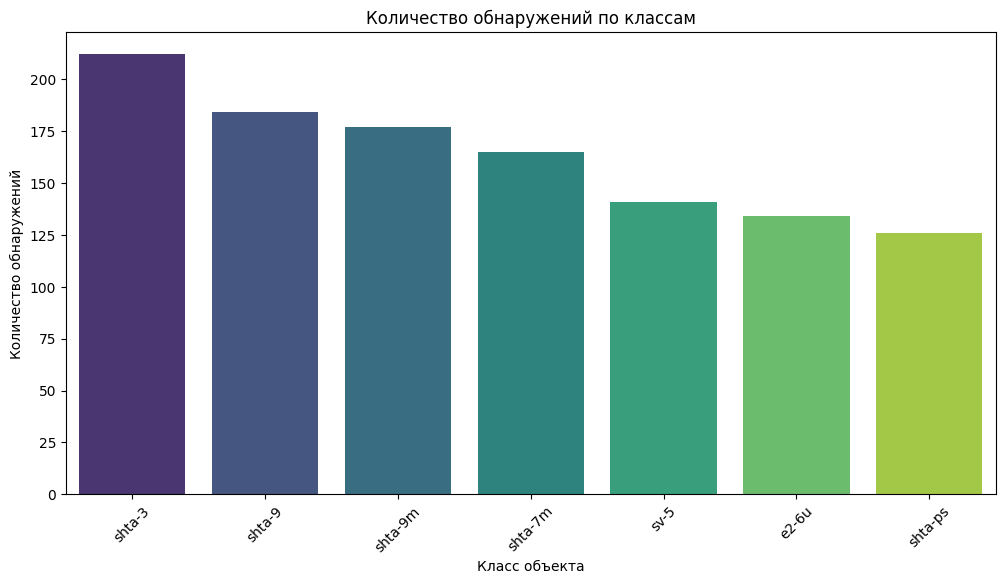


1. Количество обнаружений по классам:
class_name
shta-3     212
shta-9     184
shta-9m    177
shta-7m    165
sv-5       141
e2-6u      134
shta-ps    126
Name: count, dtype: int64


/tmp/ipython-input-21-641223051.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=confidence_by_class.index, y=confidence_by_class.values, palette='coolwarm')


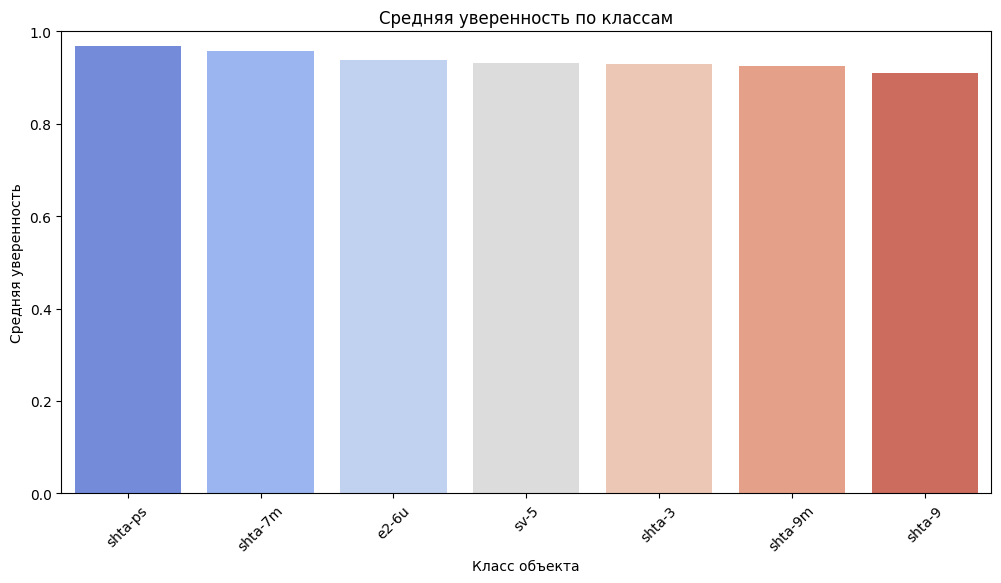


2. Средняя уверенность по классам:
class_name
shta-ps    0.968504
shta-7m    0.956542
e2-6u      0.937401
sv-5       0.931937
shta-3     0.929199
shta-9m    0.924543
shta-9     0.910350
Name: confidence, dtype: float64


/tmp/ipython-input-21-641223051.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='class_name', y='width', palette='Set3')


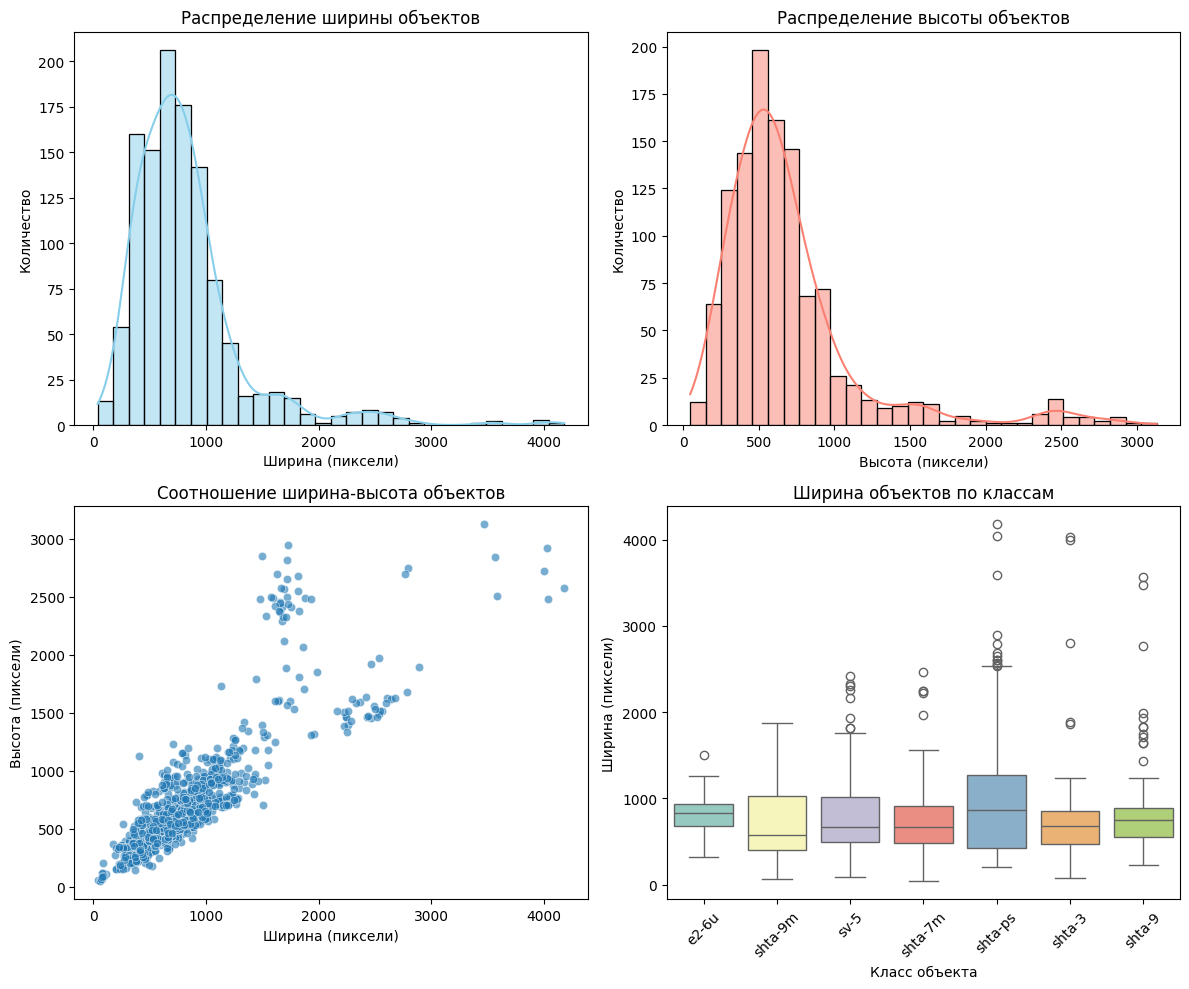


3. Статистика размеров объектов:
             width       height
count  1139.000000  1139.000000
mean    812.724678   685.333311
std     500.751462   465.489647
min      37.791895    47.284840
25%     502.183312   419.965337
50%     715.607790   576.166710
75%     948.647434   772.673025
max    4182.405280  3128.854570

4. Изображения без детекций: 4
Список сохранен в: /content/detection_results/images_without_detections.csv

Анализ результатов детекции:
------------------------------------
1. Общее количество обнаруженных объектов: 1139
2. Количество обработанных изображений: 935
3. Изображений с детекциями: 931
4. Изображений без детекций: 4
5. Средняя уверенность по всем объектам: 0.9350
6. Минимальная уверенность: 0.5028
7. Максимальная уверенность: 0.9996

Распределение по классам:
class_name
shta-3     212
shta-9     184
shta-9m    177
shta-7m    165
sv-5       141
e2-6u      134
shta-ps    126

Средняя уверенность по классам:
class_name
shta-ps    0.968504
shta-7m    0.956542
e

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/detection_results/detection_results.csv')

class_counts = df['class_name'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Количество обнаружений по классам')
plt.xlabel('Класс объекта')
plt.ylabel('Количество обнаружений')
plt.xticks(rotation=45)
plt.savefig('/content/detection_results/class_counts.png')
plt.show()

print("\n1. Количество обнаружений по классам:")
print(class_counts)

confidence_by_class = df.groupby('class_name')['confidence'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=confidence_by_class.index, y=confidence_by_class.values, palette='coolwarm')
plt.title('Средняя уверенность по классам')
plt.xlabel('Класс объекта')
plt.ylabel('Средняя уверенность')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.savefig('/content/detection_results/confidence_by_class.png')
plt.show()

print("\n2. Средняя уверенность по классам:")
print(confidence_by_class)

df['width'] = df['xmax'] - df['xmin']
df['height'] = df['ymax'] - df['ymin']

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['width'], bins=30, kde=True, color='skyblue')
plt.title('Распределение ширины объектов')
plt.xlabel('Ширина (пиксели)')
plt.ylabel('Количество')

plt.subplot(2, 2, 2)
sns.histplot(df['height'], bins=30, kde=True, color='salmon')
plt.title('Распределение высоты объектов')
plt.xlabel('Высота (пиксели)')
plt.ylabel('Количество')

plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='width', y='height', alpha=0.6)
plt.title('Соотношение ширина-высота объектов')
plt.xlabel('Ширина (пиксели)')
plt.ylabel('Высота (пиксели)')

plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='class_name', y='width', palette='Set3')
plt.title('Ширина объектов по классам')
plt.xlabel('Класс объекта')
plt.ylabel('Ширина (пиксели)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('/content/detection_results/object_size_distribution.png')
plt.show()

print("\n3. Статистика размеров объектов:")
print(df[['width', 'height']].describe())

all_images = set(inference_dataset.images)
detected_images = set(df['image_name'].unique())
no_detection_images = list(all_images - detected_images)

no_detection_df = pd.DataFrame({
    'image_name': no_detection_images,
    'detection_status': 'No objects detected'
})

no_detection_path = '/content/detection_results/images_without_detections.csv'
no_detection_df.to_csv(no_detection_path, index=False)

print(f"\n4. Изображения без детекций: {len(no_detection_images)}")
print(f"Список сохранен в: {no_detection_path}")

analysis_report = f"""
Анализ результатов детекции:
------------------------------------
1. Общее количество обнаруженных объектов: {len(df)}
2. Количество обработанных изображений: {len(all_images)}
3. Изображений с детекциями: {len(detected_images)}
4. Изображений без детекций: {len(no_detection_images)}
5. Средняя уверенность по всем объектам: {df['confidence'].mean():.4f}
6. Минимальная уверенность: {df['confidence'].min():.4f}
7. Максимальная уверенность: {df['confidence'].max():.4f}

Распределение по классам:
{class_counts.to_string()}

Средняя уверенность по классам:
{confidence_by_class.to_string()}
"""

with open('/content/detection_results/analysis_report.txt', 'w') as f:
    f.write(analysis_report)

print(analysis_report)
print("Анализ завершен! Все результаты сохранены в /content/detection_results")

## F1 and val metrics

In [ ]:
from torchvision.ops import box_iou

def calculate_f1_per_class(model, data_loader, device, iou_threshold=0.5, conf_threshold=0.5):
    model.eval()

    class_stats = {}
    for class_id in CLASSES.keys():
        if class_id == 0:
            continue
        class_stats[class_id] = {
            'true_positives': 0,
            'false_positives': 0,
            'false_negatives': 0
        }

    global_tp = 0
    global_fp = 0
    global_fn = 0

    with torch.no_grad():
        for images_list, targets_list, img_names in data_loader:
            if images_list is None or len(images_list) == 0:
                continue

            images = [img.to(device) for img in images_list]
            outputs = model(images)

            for i, (output, target) in enumerate(zip(outputs, targets_list)):
                keep = output['scores'] > conf_threshold
                pred_boxes = output['boxes'][keep]
                pred_labels = output['labels'][keep]
                pred_scores = output['scores'][keep]

                gt_boxes = target['boxes'].to(device)
                gt_labels = target['labels'].to(device)

                for class_id in class_stats.keys():
                    class_mask = pred_labels == class_id
                    pred_class_boxes = pred_boxes[class_mask]

                    gt_class_mask = gt_labels == class_id
                    gt_class_boxes = gt_boxes[gt_class_mask]

                    if len(pred_class_boxes) > 0:
                        if len(gt_class_boxes) > 0:
                            iou_matrix = box_iou(pred_class_boxes, gt_class_boxes)

                            matched_gt = set()
                            for pred_idx in range(len(pred_class_boxes)):
                                max_iou, gt_idx = iou_matrix[pred_idx].max(0)

                                if max_iou >= iou_threshold and gt_idx not in matched_gt:
                                    class_stats[class_id]['true_positives'] += 1
                                    global_tp += 1
                                    matched_gt.add(gt_idx)
                                else:
                                    class_stats[class_id]['false_positives'] += 1
                                    global_fp += 1

                            unmatched_gt = len(gt_class_boxes) - len(matched_gt)
                            class_stats[class_id]['false_negatives'] += unmatched_gt
                            global_fn += unmatched_gt
                        else:
                            class_stats[class_id]['false_positives'] += len(pred_class_boxes)
                            global_fp += len(pred_class_boxes)
                    else:
                        if len(gt_class_boxes) > 0:
                            class_stats[class_id]['false_negatives'] += len(gt_class_boxes)
                            global_fn += len(gt_class_boxes)

    class_metrics = {}
    macro_f1 = 0
    macro_precision = 0
    macro_recall = 0
    total_support = 0
    total_weighted_f1 = 0
    total_weighted_precision = 0
    total_weighted_recall = 0

    for class_id, stats in class_stats.items():
        tp = stats['true_positives']
        fp = stats['false_positives']
        fn = stats['false_negatives']

        precision = tp / (tp + fp + 1e-10)
        recall = tp / (tp + fn + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        support = tp + fn

        class_metrics[class_id] = {
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'support': support
        }

        macro_f1 += f1
        macro_precision += precision
        macro_recall += recall

        total_support += support
        total_weighted_f1 += f1 * support
        total_weighted_precision += precision * support
        total_weighted_recall += recall * support

    num_classes = len(class_stats)
    macro_f1 /= num_classes if num_classes > 0 else 1
    macro_precision /= num_classes if num_classes > 0 else 1
    macro_recall /= num_classes if num_classes > 0 else 1

    weighted_f1 = total_weighted_f1 / (total_support + 1e-10)
    weighted_precision = total_weighted_precision / (total_support + 1e-10)
    weighted_recall = total_weighted_recall / (total_support + 1e-10)

    micro_precision = global_tp / (global_tp + global_fp + 1e-10)
    micro_recall = global_tp / (global_tp + global_fn + 1e-10)
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-10)

    summary_metrics = {
        'micro': {
            'f1': micro_f1,
            'precision': micro_precision,
            'recall': micro_recall,
            'support': global_tp + global_fn
        },
        'macro': {
            'f1': macro_f1,
            'precision': macro_precision,
            'recall': macro_recall
        },
        'weighted': {
            'f1': weighted_f1,
            'precision': weighted_precision,
            'recall': weighted_recall
        },
        'total_tp': global_tp,
        'total_fp': global_fp,
        'total_fn': global_fn
    }

    return class_metrics, summary_metrics

In [ ]:
model = load_model_for_inference(MODEL_PATH, NUM_CLASSES, DEVICE)
model.to(DEVICE)

class_metrics, summary_metrics = calculate_f1_per_class(model, test_loader, DEVICE)

print("\nДетальные метрики по классам:")
for class_id, metrics in class_metrics.items():
    class_name = CLASSES[class_id]
    print(f"{class_name} (ID: {class_id}):")
    print(f"  F1-Score: {metrics['f1']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  Support: {metrics['support']}")
    print()

print("\nИтоговые метрики по всем классам:")
print(f"Общее количество объектов: {summary_metrics['micro']['support']}")
print(f"True Positives (TP): {summary_metrics['total_tp']}")
print(f"False Positives (FP): {summary_metrics['total_fp']}")
print(f"False Negatives (FN): {summary_metrics['total_fn']}")
print()

print("Микро-усреднение (глобальный подсчет):")
print(f"  F1-Score: {summary_metrics['micro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['micro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['micro']['recall']:.4f}")
print()

print("Макро-усреднение (среднее по классам):")
print(f"  F1-Score: {summary_metrics['macro']['f1']:.4f}")
print(f"  Precision: {summary_metrics['macro']['precision']:.4f}")
print(f"  Recall: {summary_metrics['macro']['recall']:.4f}")
print()

print("Взвешенное усреднение (по количеству объектов):")
print(f"  F1-Score: {summary_metrics['weighted']['f1']:.4f}")
print(f"  Precision: {summary_metrics['weighted']['precision']:.4f}")
print(f"  Recall: {summary_metrics['weighted']['recall']:.4f}")


Детальные метрики по классам:
shta-9m (ID: 1):
  F1-Score: 0.6792
  Precision: 0.5625
  Recall: 0.8571
  Support: 21

shta-ps (ID: 2):
  F1-Score: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  Support: 21

shta-7m (ID: 3):
  F1-Score: 0.7895
  Precision: 0.8333
  Recall: 0.7500
  Support: 20

e2-6u (ID: 4):
  F1-Score: 0.8333
  Precision: 0.7692
  Recall: 0.9091
  Support: 22

shta-9 (ID: 5):
  F1-Score: 0.8070
  Precision: 0.7187
  Recall: 0.9200
  Support: 25

shta-3 (ID: 6):
  F1-Score: 0.7869
  Precision: 0.6857
  Recall: 0.9231
  Support: 26

sv-5 (ID: 7):
  F1-Score: 0.8077
  Precision: 0.7241
  Recall: 0.9130
  Support: 23


Итоговые метрики по всем классам:
Общее количество объектов: 158
True Positives (TP): 142
False Positives (FP): 51
False Negatives (FN): 16

Микро-усреднение (глобальный подсчет):
  F1-Score: 0.8091
  Precision: 0.7358
  Recall: 0.8987

Макро-усреднение (среднее по классам):
  F1-Score: 0.8148
  Precision: 0.7562
  Recall: 0.8961

Взвешенное усреднение (по 

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches

def visualize_metrics(class_metrics, summary_metrics, classes_dict, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)

    class_data = []
    filtered_class_metrics = {k: v for k, v in class_metrics.items() if v['support'] > 0 or classes_dict[k] != 'unknown'}

    for class_id, metrics in filtered_class_metrics.items():
        class_name = classes_dict[class_id]
        class_data.append({
            'Class': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Support': metrics['support']
        })

    df_class_report = pd.DataFrame(class_data)

    if df_class_report.empty:
        print("No classes with support > 0 found for visualization.")
        return {}

    plt.figure(figsize=(12, 6))
    plt.bar(df_class_report['Class'], df_class_report['F1-Score'], color='skyblue')
    plt.axhline(y=summary_metrics['macro']['f1'], color='r', linestyle='--',
                label=f'Macro F1-Score: {summary_metrics["macro"]["f1"]:.4f}')
    plt.title('F1-Score по классам')
    plt.xlabel('Класс')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    f1_by_class_path = os.path.join(save_dir, 'f1_by_class.png')
    plt.savefig(f1_by_class_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 8))
    sns.heatmap(df_class_report[['Precision', 'Recall', 'F1-Score']],
                annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=['Precision', 'Recall', 'F1-Score'],
                yticklabels=df_class_report['Class'])
    plt.title('Метрики по классам')
    plt.tight_layout()
    heatmap_path = os.path.join(save_dir, 'metrics_heatmap.png')
    plt.savefig(heatmap_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 8))

    min_precision = df_class_report['Precision'].min()
    min_recall = df_class_report['Recall'].min()
    max_precision = df_class_report['Precision'].max()
    max_recall = df_class_report['Recall'].max()

    buffer = 0.05
    x_min = max(0.0, min_recall - buffer)
    x_max = min(1.0, max_recall + buffer)
    y_min = max(0.0, min_precision - buffer)
    y_max = min(1.0, max_precision + buffer)

    x_min = min(x_min, x_max - 0.01)
    y_min = min(y_min, y_max - 0.01)

    for _, row in df_class_report.iterrows():
        plt.scatter(row['Recall'], row['Precision'], s=120, edgecolors='black')
        plt.text(
            row['Recall'],
            row['Precision'] + 0.005,
            f"{row['Class']}\nF1={row['F1-Score']:.4f}",
            fontsize=9,
            ha='center',
            va='bottom',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
        )

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall по классам')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)

    for f1 in [0.5, 0.7, 0.9]:
        x_iso = np.linspace(x_min, x_max, 100)
        with np.errstate(divide='ignore', invalid='ignore'):
            y_iso = np.where(
                (2 * x_iso - f1) != 0,
                f1 * x_iso / (2 * x_iso - f1),
                np.nan
            )

        valid_points = (~np.isnan(y_iso)) & (y_iso >= y_min) & (y_iso <= y_max)

        if np.any(valid_points):
            valid_indices = np.where(valid_points)[0]
            breaks = np.where(np.diff(valid_indices) != 1)[0]
            segments = np.split(valid_indices, breaks + 1)

            for segment_indices in segments:
                if len(segment_indices) > 1:
                    plt.plot(x_iso[segment_indices], y_iso[segment_indices], 'r--', alpha=0.3, linewidth=0.8)

            if segments and len(segments[-1]) > 0:
                last_idx_in_segment = segments[-1][-1]
                plt.text(x_iso[last_idx_in_segment], y_iso[last_idx_in_segment], f"F1={f1}",
                         color='red', fontsize=8, ha='right', va='bottom')

    plt.tight_layout()
    pr_path = os.path.join(save_dir, 'precision_recall.png')
    plt.savefig(pr_path)
    plt.show()
    plt.close()

    metrics_types = ['micro', 'macro', 'weighted']
    metric_names = ['f1', 'precision', 'recall']

    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    index = np.arange(len(metrics_types))

    for i, metric in enumerate(metric_names):
        values = [summary_metrics[m_type][metric] for m_type in metrics_types]
        plt.bar(index + i * bar_width, values, bar_width, label=metric.capitalize())

    plt.xlabel('Тип усреднения')
    plt.ylabel('Значение метрики')
    plt.title('Сравнение микро, макро и взвешенных метрик')
    plt.xticks(index + bar_width/2, [t.capitalize() for t in metrics_types])
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    summary_path = os.path.join(save_dir, 'summary_metrics.png')
    plt.savefig(summary_path)
    plt.show()
    plt.close()

    csv_path = os.path.join(save_dir, 'metrics_report.csv')
    df_class_report.to_csv(csv_path, index=False)

    summary_data = []
    for m_type in metrics_types:
        for metric in metric_names:
            summary_data.append({
                'Type': m_type,
                'Metric': metric,
                'Value': summary_metrics[m_type][metric]
            })

    summary_df = pd.DataFrame(summary_data)
    summary_csv_path = os.path.join(save_dir, 'summary_metrics.csv')
    summary_df.to_csv(summary_csv_path, index=False)

    return {
        'f1_by_class': f1_by_class_path,
        'metrics_heatmap': heatmap_path,
        'precision_recall': pr_path,
        'summary_metrics': summary_path,
        'class_report_csv': csv_path,
        'summary_report_csv': summary_csv_path
    }

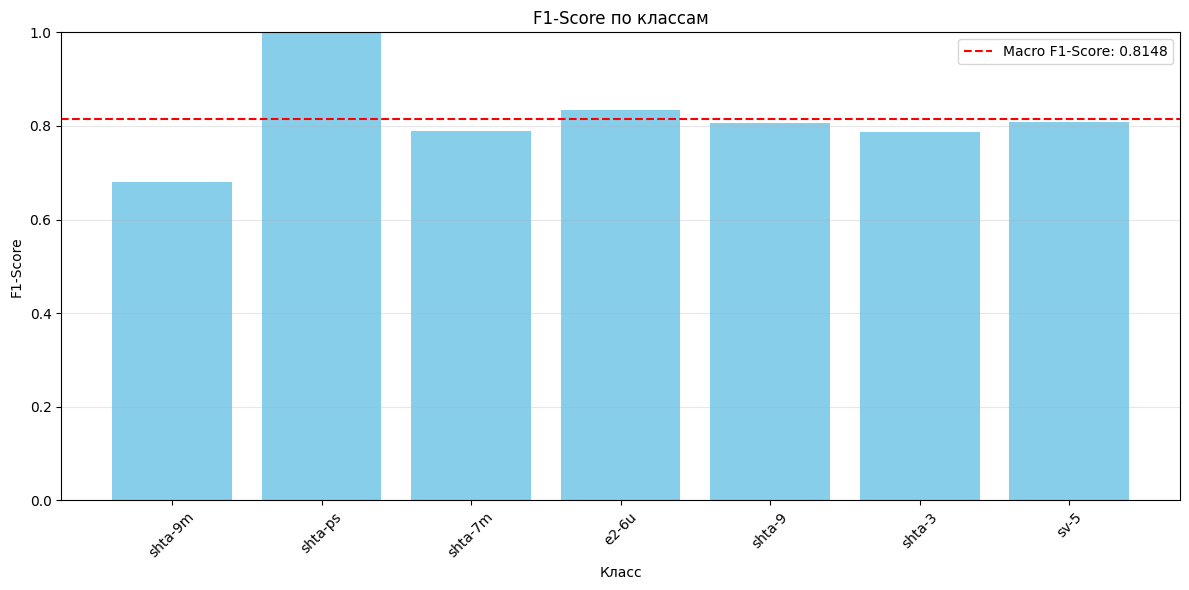

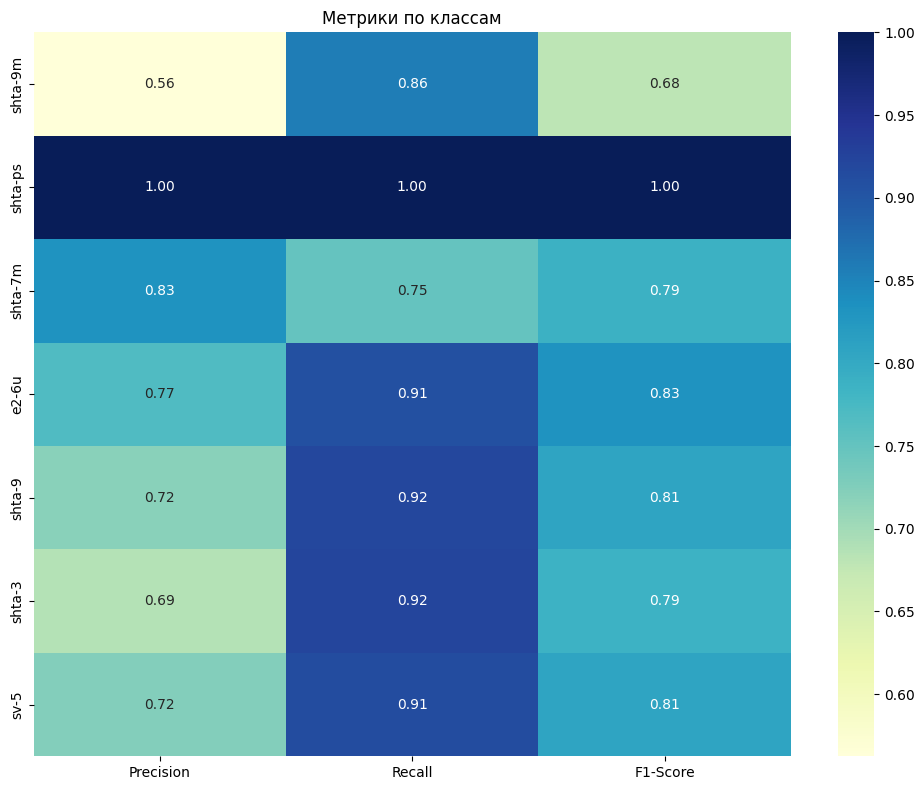

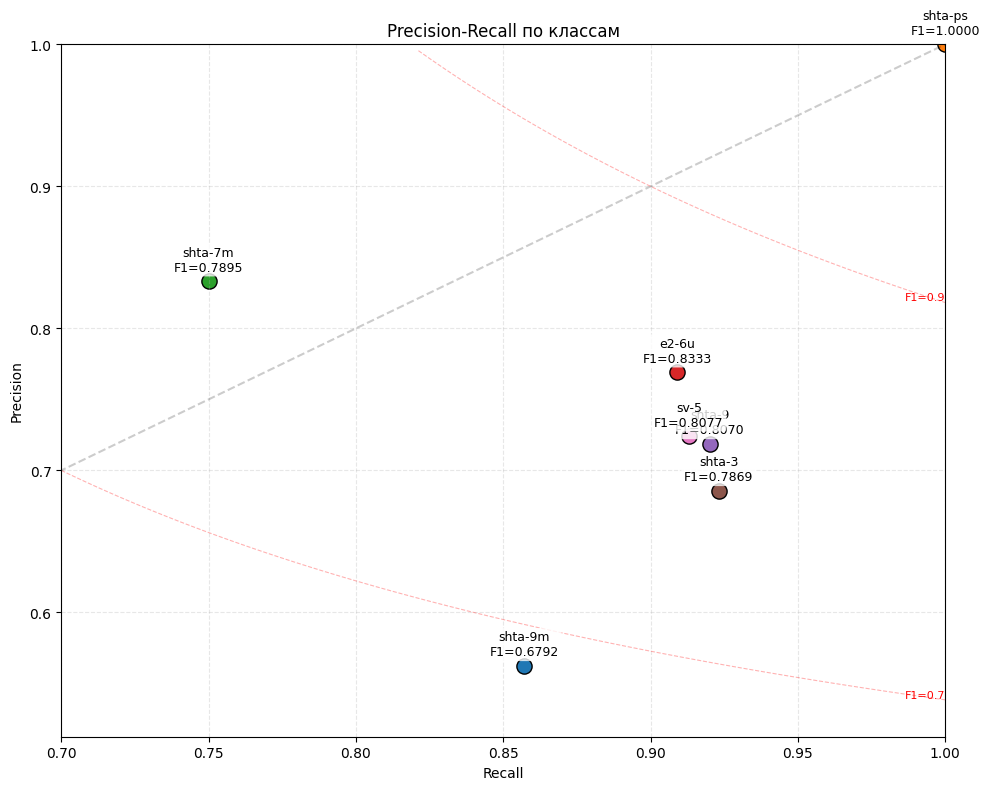

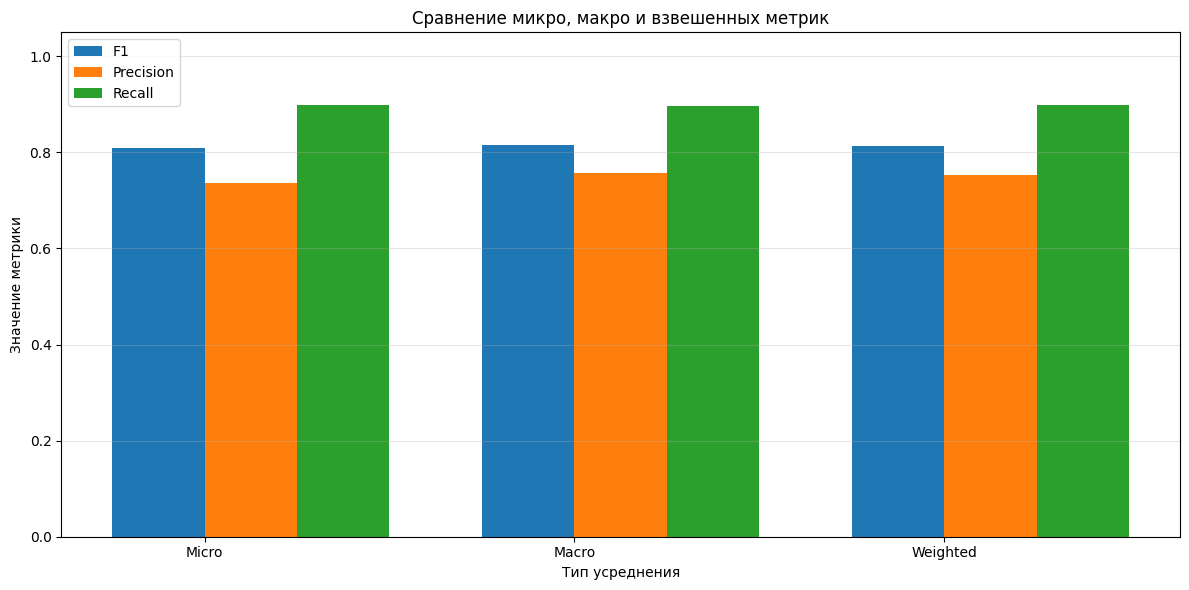

In [ ]:
visualization_paths = visualize_metrics(
    class_metrics=class_metrics,
    summary_metrics=summary_metrics,
    classes_dict=CLASSES,
    save_dir="metrics_results"
)

In [ ]:
shutil.copytree('/content/detection_results', os.path.join(save_folder, "detection_results"))

print(f"All results saved to: {save_folder}")

All results saved to: /content/drive/MyDrive/object_detection_results/2025-06-30_10-29-13


In [ ]:
shutil.copytree('/content/metrics_results', os.path.join(save_folder, "metrics_results"))

print(f"All results saved to: {save_folder}")

All results saved to: /content/drive/MyDrive/object_detection_results/2025-06-30_10-29-13
